# Test BaSiC output with reference implementation

### Installing the PyBaSiC

In [1]:
!git clone https://github.com/peng-lab/BaSiCPy.git
import os
os.chdir(os.getcwd()+'/BaSiCPy')
!git checkout f3fcf19 # the reference implementation by @mahdilamb
!pip install -e .

Cloning into 'BaSiCPy'...
remote: Enumerating objects: 1076, done.
remote: Counting objects: 100% (117/117), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 1076 (delta 104), reused 98 (delta 98), pack-reused 959
Receiving objects: 100% (1076/1076), 194.06 MiB | 15.98 MiB/s, done.
Resolving deltas: 100% (356/356), done.
Checking out files: 100% (379/379), done.
Note: checking out 'f3fcf19'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at f3fcf19 Update inexact_alm_rspca_l1.py (#1)
Obtaining file:///content/BaSiCPy
  Attempting uninstall: pybasic
    Found existing installation: pybasic 0.0.0
    Can't

### Importing the package

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pybasic

### Reading the input images

In [3]:
# copy from basicpy.data to download Zenodo dataset

import pooch
from os import path
from skimage.io import imread
import glob

EXPERIMENTAL_TEST_DATA_PROPS = {
    "cell_culture": {
        "filename": "Cell_culture.zip",
        "hash": "md5:797bbc4c891e5fe59f4200e771b55c3a",
    },
    "timelapse_brightfield": {
        "filename": "Timelapse_brightfield.zip",
        "hash": "md5:460e5f78ac69856705704fedad9f9e59",
    },
    "timelapse_nanog": {
        "filename": "Timelapse_nanog.zip.zip",
        "hash": "md5:815d53cac35b671269b17bd627d7baa7",
    },
    "timelapse_pu1": {
        "filename": "Timelapse_Pu1.zip.zip",
        "hash": "md5:bee97561e87c51e90b46da9b439e8b7b",
    },
    "wsi_brain": {
        "filename": "WSI_Brain.zip",
        "hash": "md5:6e163786ddec2a690aa4bb47a64bcded",
    },
}

POOCH = pooch.create(
    path=pooch.os_cache("basicpy"),
    # Use the Zenodo DOI
    base_url="doi:10.5281/zenodo.6334809/",
    registry={v["filename"]: v["hash"] for v in EXPERIMENTAL_TEST_DATA_PROPS.values()},
)

def fetch(data_name: str):
    """Fetch a sample dataset from Zenodo.
    Args:
        data_name: The name of the dataset. Must be one of ["cell_culture",
            "timelapse_brightfield", "timelapse_nanog", "timelapse_pu1",
            "wsi_brain"].

    Returns:
        Iterable[ndarray]: An iterable of uncorrected images.
        Iterable[ndarray]: An iterable of corrected images by the reference
            implementation (Tingying Peng et al., Nature Communication 8:14836 (2017).)

    Raises:
        ValueError: If the dataset name is not one of the allowed values.
    """
    if data_name not in EXPERIMENTAL_TEST_DATA_PROPS.keys():
        raise ValueError(f"{data_name} is not a valid test data name")
    file_name = EXPERIMENTAL_TEST_DATA_PROPS[data_name]["filename"]
    test_file_paths = POOCH.fetch(file_name, processor=pooch.Unzip())
    assert all(path.exists(f) for f in test_file_paths)
    basedir = path.commonpath(test_file_paths)
    uncorrected_paths = sorted(
        glob.glob(path.join(basedir, "Uncorrected*", "**", "*.tif"), recursive=True)
    )
    if len(uncorrected_paths) == 0:
        uncorrected_paths = sorted(
            glob.glob(path.join(basedir, "Uncorrected*", "**", "*.png"), recursive=True)
        )
    corrected_paths = sorted(
        glob.glob(path.join(basedir, "Corrected*", "**", "*.tif"), recursive=True)
    )
    if "WSI_Brain" in file_name:
        uncorrected_paths = list(
            filter(lambda p: "BrainSection" in p, uncorrected_paths)
        )
        corrected_paths = list(filter(lambda p: "BrainSection" in p, corrected_paths))

    assert len(uncorrected_paths) > 0
    assert len(uncorrected_paths) == len(corrected_paths)
    uncorrected = (imread(f) for f in uncorrected_paths)
    corrected = (imread(f) for f in corrected_paths)

    return uncorrected, corrected

# Calculate reference implementation result

## Download data

cell_culture uint16


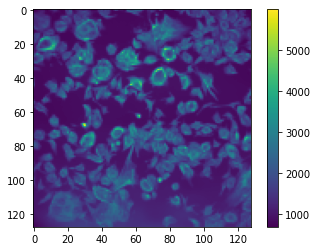

timelapse_brightfield uint8


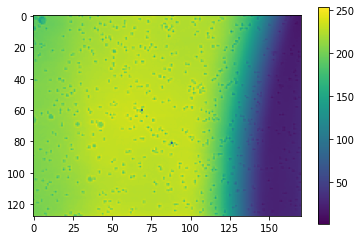

timelapse_nanog uint8


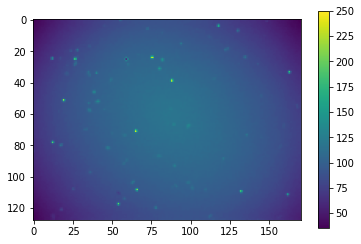

timelapse_pu1 uint8


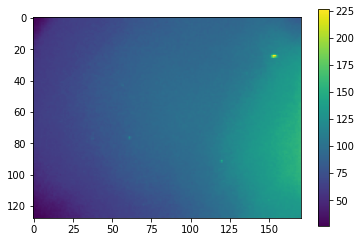

wsi_brain uint16


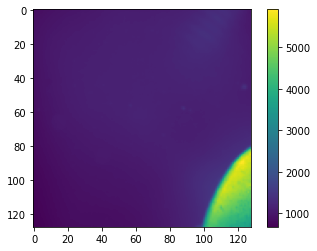

In [13]:
from skimage.transform import rescale

image_keys=list(EXPERIMENTAL_TEST_DATA_PROPS.keys())

def normalize(x,q_vals):
    qs = np.quantile(x, q_vals)
    return (x - qs[0]) / (qs[1] - qs[0]) *0.99+0.01

images_smalls={}
for k in image_keys:
  images,_=fetch(k)
  images=np.array(list(images))
  dtype=images.dtype
  print(k,dtype)
  images=images.astype(np.float32)
  q_vals= [0, 0.99999]# if image_keys not in ["cell_culture","timelapse_nanog"] else [0,1]
  images_small=(normalize(np.array([
                  rescale(im,128/np.min(images.shape[1:]),preserve_range=True) 
                            for im in images]),q_vals)*np.iinfo(dtype).max).astype(dtype)
  images_smalls[k]=images_small
  plt.imshow(images_small[10])
  plt.colorbar()
  plt.show()

cell_culture


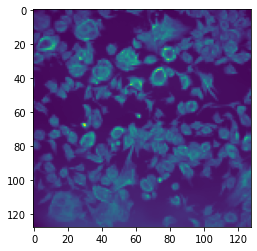

reweighting_iter: 1


/content/BaSiCPy/pybasic/tools/inexact_alm_rspca_l1.py:118: RuntimeWarning: divide by zero encountered in true_divide
  B1_offset = np.minimum(B1_offset, B1_uplimit / np.mean(W_idct_hat))


reweighting_iter: 2
reweighting_iter: 3
reweighting_iter: 4
reweighting_iter: 5
reweighting_iter: 6


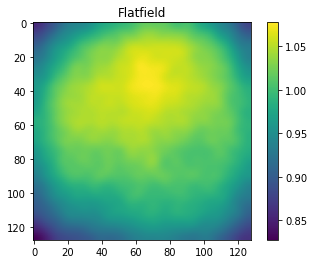

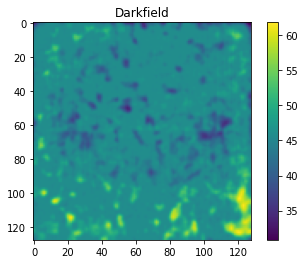

reweighting_iter: 1
reweighting_iter: 2
reweighting_iter: 3
reweighting_iter: 4
reweighting_iter: 5


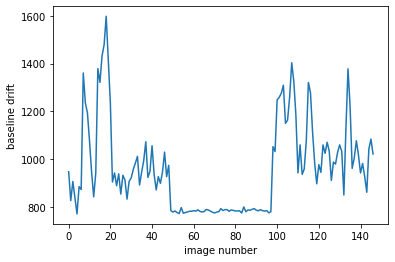

reweighting_iter: 1
reweighting_iter: 2
reweighting_iter: 3
reweighting_iter: 4


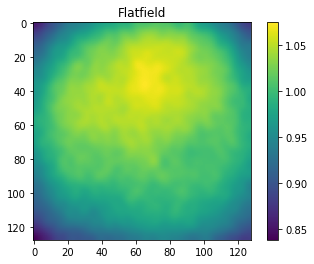

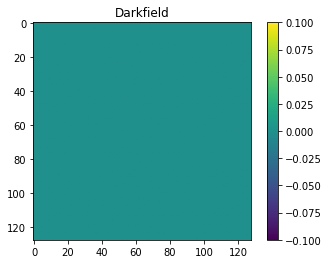

reweighting_iter: 1
reweighting_iter: 2
reweighting_iter: 3
reweighting_iter: 4
reweighting_iter: 5


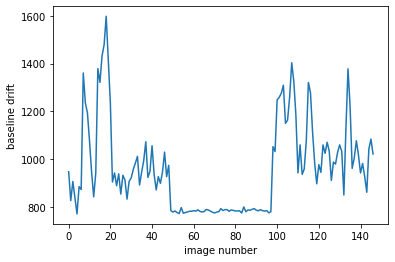

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

timelapse_brightfield


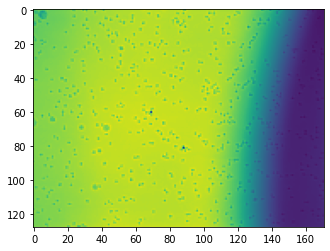

reweighting_iter: 1


/content/BaSiCPy/pybasic/tools/inexact_alm_rspca_l1.py:118: RuntimeWarning: divide by zero encountered in double_scalars
  B1_offset = np.minimum(B1_offset, B1_uplimit / np.mean(W_idct_hat))


reweighting_iter: 2
reweighting_iter: 3
reweighting_iter: 4
reweighting_iter: 5
reweighting_iter: 6


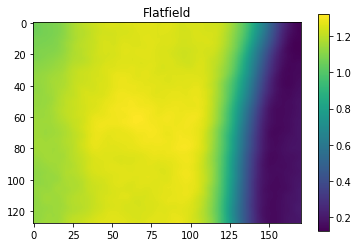

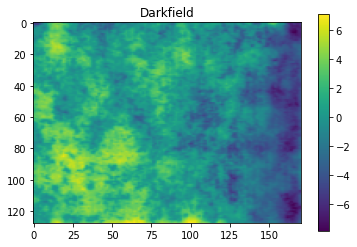

reweighting_iter: 1
reweighting_iter: 2
reweighting_iter: 3
reweighting_iter: 4
reweighting_iter: 5


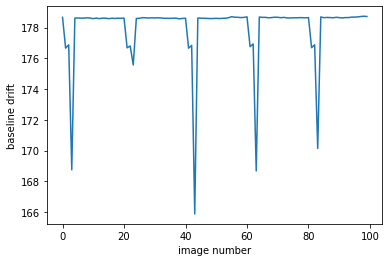

reweighting_iter: 1
reweighting_iter: 2


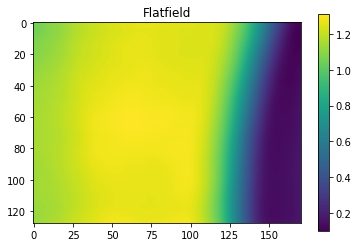

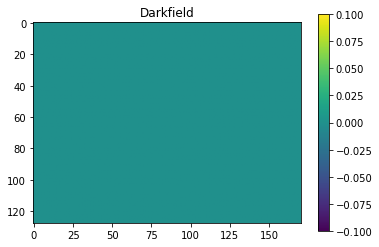

reweighting_iter: 1
reweighting_iter: 2
reweighting_iter: 3
reweighting_iter: 4
reweighting_iter: 5


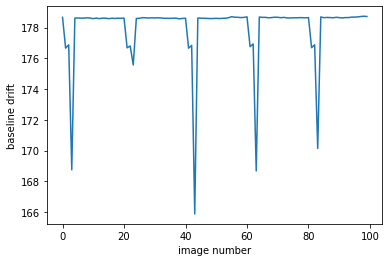

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

timelapse_nanog


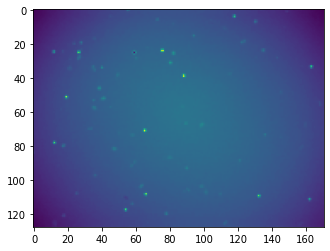

reweighting_iter: 1


/content/BaSiCPy/pybasic/tools/inexact_alm_rspca_l1.py:118: RuntimeWarning: divide by zero encountered in double_scalars
  B1_offset = np.minimum(B1_offset, B1_uplimit / np.mean(W_idct_hat))


reweighting_iter: 2
reweighting_iter: 3
reweighting_iter: 4
reweighting_iter: 5
reweighting_iter: 6
reweighting_iter: 7
reweighting_iter: 8
reweighting_iter: 9
reweighting_iter: 10


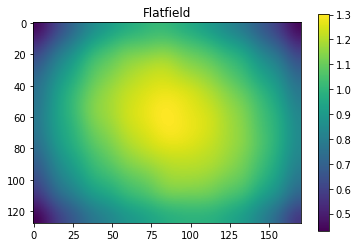

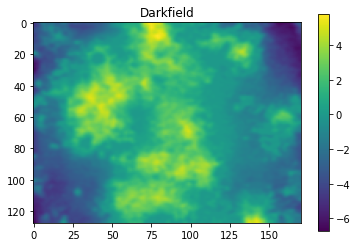

reweighting_iter: 1
reweighting_iter: 2
reweighting_iter: 3
reweighting_iter: 4
reweighting_iter: 5


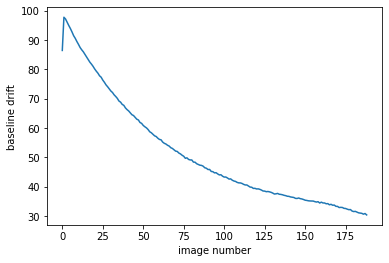

reweighting_iter: 1
reweighting_iter: 2
reweighting_iter: 3
reweighting_iter: 4
reweighting_iter: 5
reweighting_iter: 6


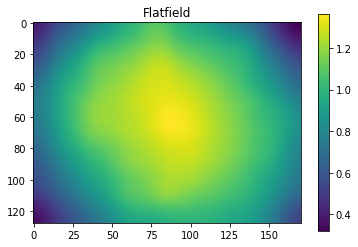

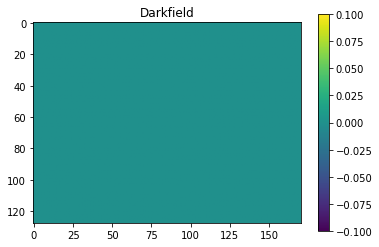

reweighting_iter: 1
reweighting_iter: 2
reweighting_iter: 3
reweighting_iter: 4
reweighting_iter: 5


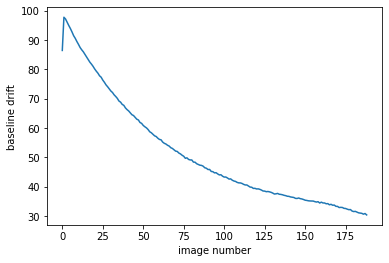

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

timelapse_pu1


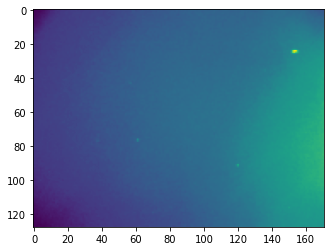

reweighting_iter: 1


/content/BaSiCPy/pybasic/tools/inexact_alm_rspca_l1.py:118: RuntimeWarning: divide by zero encountered in double_scalars
  B1_offset = np.minimum(B1_offset, B1_uplimit / np.mean(W_idct_hat))


reweighting_iter: 2
reweighting_iter: 3
reweighting_iter: 4
reweighting_iter: 5
reweighting_iter: 6
reweighting_iter: 7
reweighting_iter: 8
reweighting_iter: 9
reweighting_iter: 10


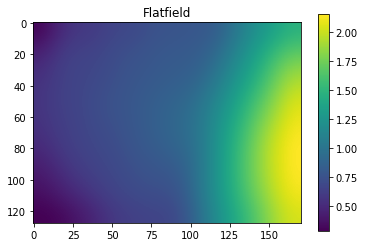

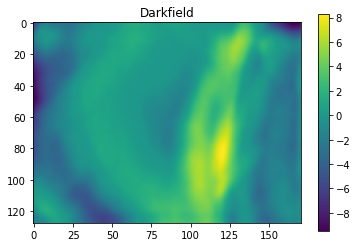

reweighting_iter: 1
reweighting_iter: 2
reweighting_iter: 3
reweighting_iter: 4
reweighting_iter: 5


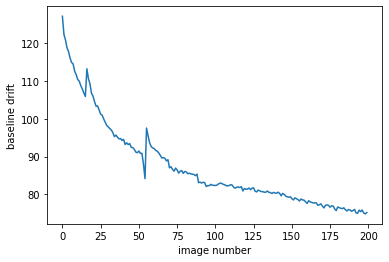

reweighting_iter: 1
reweighting_iter: 2
reweighting_iter: 3
reweighting_iter: 4


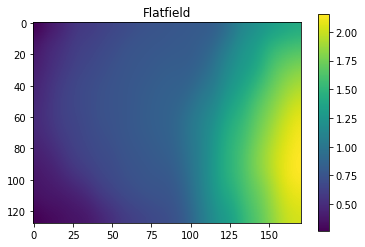

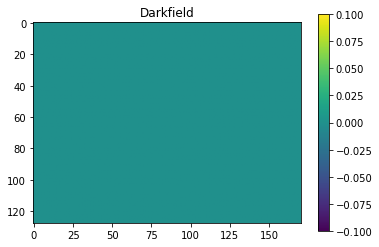

reweighting_iter: 1
reweighting_iter: 2
reweighting_iter: 3
reweighting_iter: 4
reweighting_iter: 5


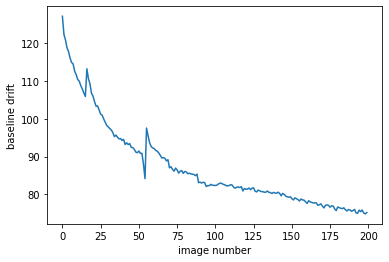

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

wsi_brain


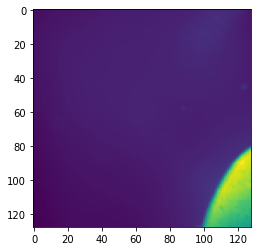

reweighting_iter: 1


/content/BaSiCPy/pybasic/tools/inexact_alm_rspca_l1.py:118: RuntimeWarning: divide by zero encountered in true_divide
  B1_offset = np.minimum(B1_offset, B1_uplimit / np.mean(W_idct_hat))


reweighting_iter: 2
reweighting_iter: 3
reweighting_iter: 4
reweighting_iter: 5
reweighting_iter: 6
reweighting_iter: 7
reweighting_iter: 8
reweighting_iter: 9
reweighting_iter: 10


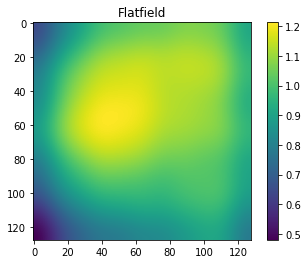

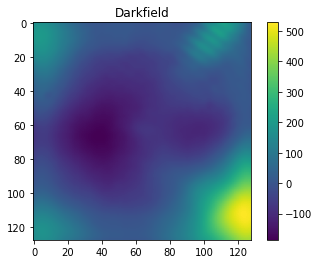

reweighting_iter: 1
reweighting_iter: 2
reweighting_iter: 3
reweighting_iter: 4
reweighting_iter: 5


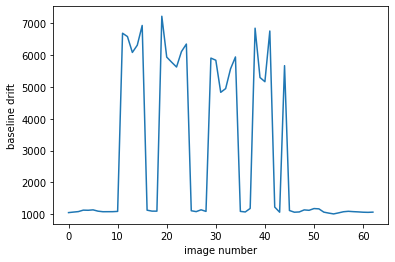

reweighting_iter: 1
reweighting_iter: 2
reweighting_iter: 3
reweighting_iter: 4
reweighting_iter: 5
reweighting_iter: 6
reweighting_iter: 7
reweighting_iter: 8


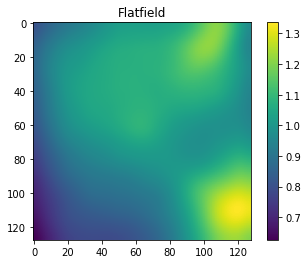

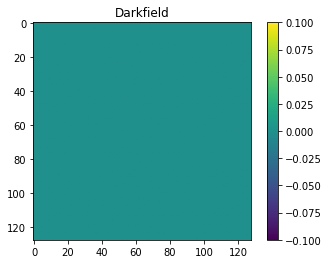

reweighting_iter: 1
reweighting_iter: 2
reweighting_iter: 3
reweighting_iter: 4
reweighting_iter: 5


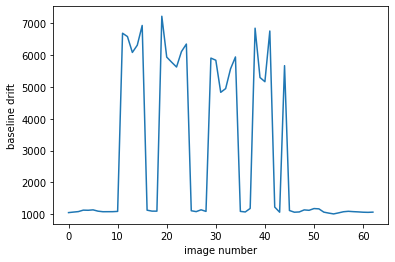

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
from google.colab import files
for k in image_keys[:]:
  print(k)
  images=images_smalls[k]#.astype(np.float32)
  plt.imshow(images[10])
  plt.show()
  flatfield, darkfield = pybasic.basic(images, darkfield=True)
  plt.title('Flatfield')
  plt.imshow(flatfield)
  plt.colorbar()
  plt.show()
  plt.title('Darkfield')
  plt.imshow(darkfield)
  plt.colorbar()
  plt.show()
  baseflour = pybasic.background_timelapse(
      images_list = images, 
      flatfield = flatfield, 
      darkfield = darkfield
  )
  plt.plot(baseflour)
  plt.ylabel("baseline drift")
  plt.xlabel("image number")
  plt.show()

  flatfield2, darkfield2 = pybasic.basic(images, darkfield=False)
  plt.title('Flatfield')
  plt.imshow(flatfield2)
  plt.colorbar()
  plt.show()
  plt.title('Darkfield')
  plt.imshow(darkfield2)
  plt.colorbar()
  plt.show()
  baseflour2 = pybasic.background_timelapse(
      images_list = images, 
      flatfield = flatfield, 
      darkfield = darkfield
  )
  plt.plot(baseflour2)
  plt.ylabel("baseline drift")
  plt.xlabel("image number")
  plt.show()

  fn=k+".npz"
  np.savez_compressed(fn,images=images_small,
                      baseline=baseflour,
                      flatfield=flatfield,
                      darkfield=darkfield,
                      baseline_flatonly=baseflour2,
                      flatfield_flatonly=flatfield2,
                      darkfield_flatonly=darkfield2
                      )
  files.download(fn)